<a href="https://colab.research.google.com/github/PrachitiSParulekar/machine-learning-end-to-end-pipeline/blob/main/Random_Forest_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("irfanasrullah/groceries")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'groceries' dataset.
Path to dataset files: /kaggle/input/groceries


In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
import os

data_path = os.path.join(path, "groceries.csv")

try:
    groceries = pd.read_csv(data_path, sep=',') # Try comma as delimiter first
except Exception as e:
    print(f"Error with comma delimiter: {e}")
    try:
        groceries = pd.read_csv(data_path, sep=' ', engine='python') # Try space as delimiter and python engine
    except Exception as e:
        print(f"Error with space delimiter and python engine: {e}")
        try:
            groceries = pd.read_csv(data_path, sep='\t', engine='python') # Try tab as delimiter and python engine
        except Exception as e:
            print(f"Error with tab delimiter and python engine: {e}")

groceries.head()

Error with comma delimiter: Error tokenizing data. C error: Expected 4 fields in line 6, saw 5

Error with space delimiter and python engine: Expected 4 fields in line 5, saw 7


,"citrus fruit,semi-finished bread,margarine,ready soups"
0,"tropical fruit,yogurt,coffee"
1,whole milk
2,"pip fruit,yogurt,cream cheese,meat spreads"
3,"other vegetables,whole milk,condensed milk,lon..."
4,"whole milk,butter,yogurt,rice,abrasive cleaner"


In [35]:
# Each row: ['milk', 'bread', 'butter']
# Convert to indicator columns for top-N frequent items
from collections import Counter

# Access the single column containing the items
items_column = groceries[groceries.columns[0]]

# Flatten the list of lists into a single list of all items
all_items = [item for sublist in items_column.apply(lambda x: x.strip("[]").replace("'", "").split(", ")) for item in sublist]
item_counts = Counter(all_items)
top_items = [item for item, count in item_counts.most_common(20)]

def basket_to_features(basket):
    items = basket.strip("[]").replace("'", "").split(", ")
    return pd.Series([int(item in items) for item in top_items], index=top_items)

X = items_column.apply(basket_to_features)
X.head()

,canned beer,soda,whole milk,bottled beer,rolls/buns,bottled water,other vegetables,newspapers,shopping bags,yogurt,coffee,pastry,chocolate,ice cream,misc. beverages,salty snack,pip fruit,"pastry,soda",pork,photo/film
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
# Example target: 'Did the basket contain "whole milk"?'
y = X['whole milk']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1948
           1       0.00      0.00      0.00        19

    accuracy                           0.99      1967
   macro avg       0.50      0.50      0.50      1967
weighted avg       0.98      0.99      0.99      1967

[[1948    0]
 [  19    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


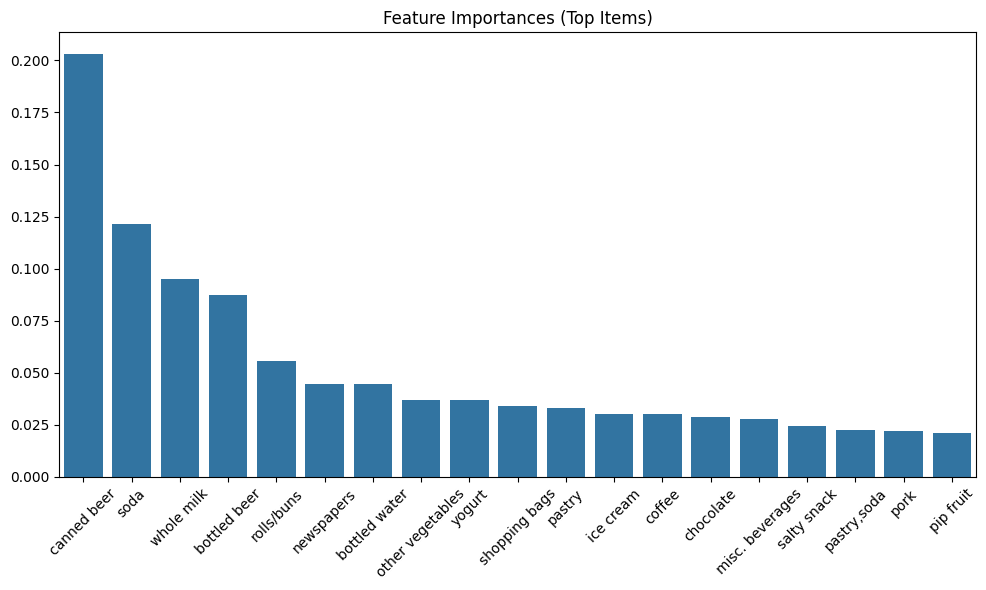

In [45]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=[top_items[i] for i in indices], y=importances[indices])
plt.xticks(rotation=45)
plt.title('Feature Importances (Top Items)')
plt.tight_layout()
plt.show()

In [47]:
# You can calculate support/confidence for an item and add as new column
# Example: Support for "yogurt" in basket
groceries['support_yogurt'] = groceries[groceries.columns[0]].apply(lambda x: int('yogurt' in x))
X['support_yogurt'] = groceries['support_yogurt']

In [48]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
model.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [49]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.13      0.23      1948
           1       0.01      1.00      0.02        19

    accuracy                           0.14      1967
   macro avg       0.51      0.57      0.13      1967
weighted avg       0.99      0.14      0.23      1967



In [50]:
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.13      0.23      1948
           1       0.01      1.00      0.02        19

    accuracy                           0.14      1967
   macro avg       0.51      0.57      0.13      1967
weighted avg       0.99      0.14      0.23      1967



In [51]:
item_freq = X.sum(axis=0)
print(item_freq.sort_values(ascending=False))

# Pick a more common item for your next target, e.g.:
target_item = 'other vegetables'
y = X[target_item]
X_ = X.drop(target_item, axis=1)

support_yogurt      1372
canned beer          260
soda                 156
bottled beer         120
rolls/buns           109
bottled water         67
other vegetables      62
newspapers            54
shopping bags         48
yogurt                40
coffee                39
pastry                37
chocolate             35
ice cream             34
misc. beverages       31
salty snack           30
pip fruit             28
pastry,soda           27
pork                  27
photo/film            27
dtype: int64


In [52]:
# Total number of top items in each basket
X['basket_size'] = X.sum(axis=1)

In [55]:
# Add a new feature: both bread and butter present in basket
# Check in the original transaction string as 'bread' is not in top_items
X['bread_and_butter'] = groceries[groceries.columns[0]].apply(lambda x: int('bread' in x and 'butter' in x))

In [54]:
from sklearn.metrics import roc_auc_score

# Only applies if your target has both classes
y_prob = model.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

ROC-AUC: 0.5664784394250513


In [56]:
target_item = 'support_yogurt'
y = X[target_item]
X_ = X.drop(target_item, axis=1)
# Then rerun train/test split and model steps

In [57]:
from sklearn.multioutput import MultiOutputClassifier
multi_target = X[['support_yogurt', 'canned beer', 'soda']]
X_features = X.drop(['support_yogurt', 'canned beer', 'soda'], axis=1)
model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
model.fit(X_features, multi_target)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [58]:
# Define item-to-category mapping (example dictionary, expand as needed)
item_to_category = {
    'whole milk': 'dairy', 'yogurt': 'dairy', 'cream cheese': 'dairy',
    'canned beer': 'drinks', 'soda': 'drinks', 'bottled beer': 'drinks',
    'rolls/buns': 'bakery', 'pastry': 'bakery', 'bread': 'bakery',
    'chocolate': 'snacks', 'salty snack': 'snacks',
    # Add more as needed...
}

def determine_basket_category(basket):
    items = basket.strip("[]").replace("'", "").split(", ")
    categories = [item_to_category.get(item, 'other') for item in items]
    # Find majority category
    return pd.Series(categories).mode()[0] if categories else 'other'

groceries['basket_category'] = groceries[groceries.columns[0]].apply(determine_basket_category)
print(groceries['basket_category'].value_counts())

# Prepare features (X already created above), drop category columns if present
X_cat = X.copy()
if 'basket_category' in X_cat.columns:
    X_cat = X_cat.drop('basket_category', axis=1)

y_cat = groceries['basket_category']

# Only keep top-N frequent categories to avoid micro-classes:
top_cats = y_cat.value_counts().nlargest(5).index.tolist()
mask = y_cat.isin(top_cats)
X_cat = X_cat[mask]
y_cat = y_cat[mask]

# Train/test split & modeling
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

basket_category
other     8922
drinks     536
dairy      165
bakery     146
snacks      65
Name: count, dtype: int64
              precision    recall  f1-score   support

      bakery       1.00      1.00      1.00        29
       dairy       1.00      0.21      0.35        33
      drinks       1.00      1.00      1.00       107
       other       0.99      1.00      0.99      1785
      snacks       1.00      1.00      1.00        13

    accuracy                           0.99      1967
   macro avg       1.00      0.84      0.87      1967
weighted avg       0.99      0.99      0.98      1967

[[  29    0    0    0    0]
 [   0    7    0   26    0]
 [   0    0  107    0    0]
 [   0    0    0 1785    0]
 [   0    0    0    0   13]]


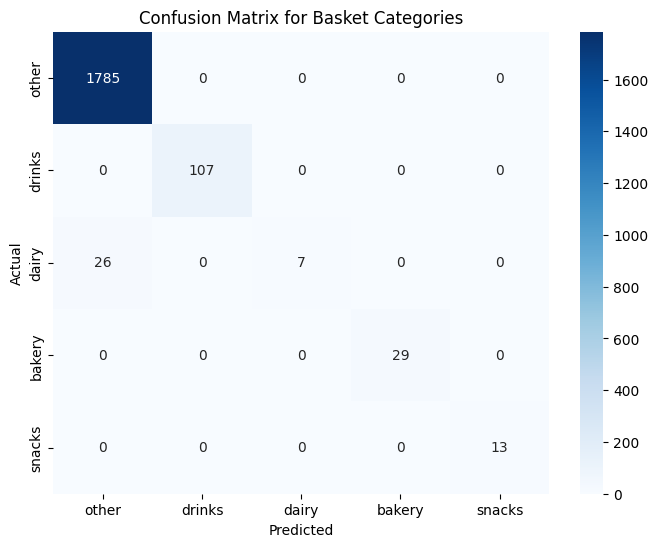

In [59]:
cm = confusion_matrix(y_test, y_pred, labels=top_cats)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=top_cats, yticklabels=top_cats, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Basket Categories')
plt.show()

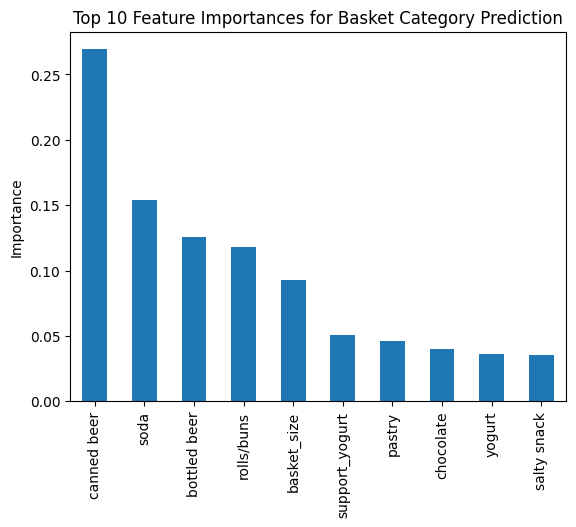

In [60]:
# Show which items most influence "basket_category" prediction
feat_imp = pd.Series(model.feature_importances_, index=X_cat.columns)
feat_imp.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Feature Importances for Basket Category Prediction")
plt.ylabel("Importance")
plt.show()

In [73]:
# See a few actual vs. predicted for error analysis
preds = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(preds.sample(10))

      Actual Predicted
3398   other     other
5430   other     other
4722  drinks    drinks
2113   other     other
2277   other     other
2983   other     other
3089   other     other
1650   dairy     other
4341   other     other
9090   other     other
